In [1]:
import torch 
print(torch.__version__)
import torch.nn as nn
import math
import copy
from torch.autograd import Variable


2.0.0


![](https://pic4.zhimg.com/80/v2-f476fbc9bc3a39d2fa65707eb0a93417_720w.webp)



# 整体结构
左边 encoder
1. MultiHead Attention 都包含add残差&norm归一化
2. MLP 

右边 decoder
1. Masked MultiHead Attention
2. MultiHead Attention 都包含add残差&norm归一化
3. MLP 

# 1.输入：embedding层

输入 x:汉语的一个字就是一个token，经过词表是 one-hot向量

返回值embedds :M * D，表示M个字的 D维度向量 （关于这里是 一个单词对应一个embeeding，一句话对应一个embedds）

In [2]:
class Embeddings(nn.Module):
    def __init__(self,d_model,vocab):
        """
        构造函数：
        d_model：维度
        vocab：词表
        """
        super(Embeddings,self).__init__()  #这里确保继承父类
        self.lut = nn.Embedding(vocab,d_model) #词嵌入对象lut
        self.d_model = d_model  #得到维度
    def forward(self,x):
        """
        Embedding层前向传播
        x:word经过词表之后的 one-hot向量
        """
        embedds = self.lut(x) #词嵌入
        return embedds * math.sqrt(self.d_model) #实现值放大，因为dimmension对其进行了稀释

        

In [3]:
# # 测试阶段
# import torch
# import torch.nn as nn

# # 定义词汇表大小和词嵌入维度
# vocab_size = 10000
# embedding_dim = 300

# # 创建一个词嵌入层
# embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# # 生成一个输入序列（假设每个句子最大长度为10）
# input_sequence = torch.LongTensor([[1, 5, 4, 3, 2, 9, 8, 7, 6, 0]])
# print(input_sequence.shape)

# # 将输入序列传递给词嵌入层
# embedded_output = embedding_layer(input_sequence)
# embedds = embedded_output * math.sqrt(embedding_dim)
# print(embedded_output)
# print(embedded_output.shape)  # 输出嵌入后的张量形状
# sum = torch.sum(embedded_output,dim = 2) #后面决定在 哪个维度 求和
# print(sum) #看上去 和不确定
# print(sum.shape)

# print("处理后的embedds: \n",embedds)



# 2.位置编码 Positional Encodding

公式：$ a = a$ 

因为tf是并行的 不像RNN是天然先后顺序，因此需要手动加入 position embedding

这里使用固定的 sin和cos函数来进行编码

特性：
1. p和p+k的内积是 与p无关 只与 k有关。

n表示序列长度 ，i表示在这个512维度张量中第几维度

t表示位置  

$\vec{p_t} \in R^d$ 表示位置向量 

f:N -> R是生成位置向量函数

$$\vec{p_t^i} = f(t)^i = 
\begin{cases}
sin(w_k * t) & ,i=2k \\
cos(w_k * t) & ,i=2k+1
\end{cases}
$$

$$w_k = \frac{1}{10000^{\frac{2k}{d}}}$$
之后的位置向量可以和词向量直接相加
$$\phi^{'}(w_t)  = \phi(w_t) + \vec{p_t}$$且有 $d_{WE} = d_{PE}$

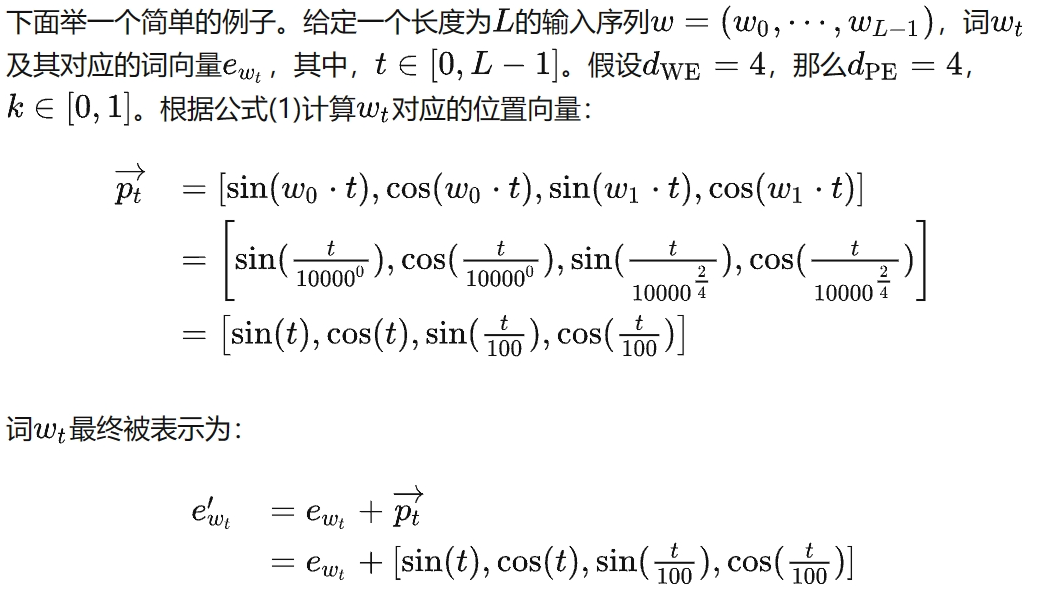

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len = 5000):
        """
        位置编码器
        
        d_model:维度
        dropout:熄灭比率
        max_len:最大长度
        """
        super(PositionalEncoding,self).__init__() # 规定一下构造函数
        self.dropout = nn.Dropout(p = dropout) #生成dropout对象
        
        #推导后 可计算的等价公式
        pe = torch.zeros(max_len,d_model) # shape = (M,d)
        position = torch.arange(0,max_len).unsqueeze(1) #5000*1的 张量 
        div_term = torch.exp(torch.arange(0,d_model,2)  * -(math.log(10000.0)/d_model)) #生成张量 (256,)，如果偶数用sin，奇数用cos，每一步的值为exp(i * -log(10000) /d_model)
        pe[:,0::2] = torch.sin(position * div_term)  #第二个维度，0开始，后面的2是步长，偶数为sin
        pe[:,1::2] = torch.cos(position * div_term)  
        pe = pe.unsqueeze(0)   #添加0维度 shape = (1,M,d)
        self.register_buffer('pe',pe) #tensor注册为固定缓存区，不训练更新，但是跟着模型一起保存和加载
    def forward(self,x):
        x = x+Variable(self.pe[:,x.size(1)],requires_grad = False) #这里把输入 加上 用得到的 位置向量（Variable一下，设置无需梯度）
        return self.dropout(x) #进行一下dropout

In [5]:
# #草稿本
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import math



# # 模拟数据
# d_model = 512
# dropout = 0.1
# max_len = 100
# batch_size = 16
# seq_length = 50

# # 创建 PositionalEncoding 对象
# pos_encoding = PositionalEncoding(d_model, dropout, max_len)

# # 生成一个随机张量作为模拟输入数据
# input_tensor = torch.randn(batch_size, seq_length, d_model)

# # 对输入数据进行前向传播
# output_tensor = pos_encoding(input_tensor)

# print("Input Tensor Shape:", input_tensor.shape)
# print("Output Tensor Shape:", output_tensor.shape)


假设我们现在做的是一个法语-英语的机器翻译任务，想把Je suis étudiant翻译为I am a student。

编码器只进行一次并行推理，即获得了对于输入的法语句子所提取的若干特征信息。

解码器，是循环推理，逐个单词生成结果的。最开始，由于什么都还没预测，我们会将编码器提取的特征，以及一个句子起始符传给解码器，解码器预期会输出一个单词I。然后有了预测的第一个单词，我们就将I输入给解码器，会再预测出下一个单词am，再然后我们将I am作为输入喂给解码器，以此类推直到预测出句子终止符完成预测。


# 3.Encoder 编码器

In [6]:
def clones(module,N):
    """
    用于把 模块复制N次 作为 encoder layer
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)]) #深拷贝方法

class Encoder(nn.Module):
    """
    Encoder整体由 N=6 的层组成
    传入参数为 encoder layer
    """
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size) #关于这一部分等会处理
    def forward(self,x,mask):
        for layer in self.layers:
            x = layer(x,mask)
        return self.norm(x)

## 3.2 编码器层
结构类似的attention和mlp，抽象为sublayer，包含 attention + （Add+Norm）

In [7]:
class SublayerConnection(nn.Module):
    """
    两个子层
    size:是layernorm的参数
    dropout:用来防止过拟合
    """
    def __init__(self,size,dropout): 
        super(SublayerConnection,self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x,sublayer): 
        """
        这里除了x，还要传入 sublayer作为外部变量
        """
        sublayer_out = sublayer(x)
        sublyaer_out = self.dropout(sublayer_out)
        x_norm = x+self.norm(sublayer_out)
        return x_norm
        